In [90]:
import os
import xarray as xr

# from helper.pre_process_target_input import normalize_data, inverse_normalize_data
import numpy as np
import matplotlib.pyplot as plt

from pysteps import io, nowcasts, rcparams
from pysteps.motion.lucaskanade import dense_lucaskanade
from pysteps.postprocessing.ensemblestats import excprob
from pysteps.utils import conversion, dimension, transformation
from pysteps.visualization import plot_precip_field

Use local conda env called 'pysteps'

Implementing STEPS nowcast:
https://pysteps.readthedocs.io/en/stable/auto_examples/plot_steps_nowcast.html

my first nowcast colab:
https://colab.research.google.com/github/pySTEPS/pysteps/blob/master/examples/my_first_nowcast.ipynb#scrollTo=CeCVjlNq3-jd
--> Transforming data from long tail to log-norm using 'dBR' unit is explained! using pysteps.utils.transformation.dB_transform()

In [91]:
folder_path = '/Users/jan/Programming/first_CNN_on_Radolan/dwd_nc/own_test_data' #'/home/jan/Programming/remote/first_CNN_on_radolan_remote/dwd_nc/own_test_data'
file_name_radolan = 'testdata_two_days_2019_01_01-02.zarr'
load_path = os.path.join(folder_path, file_name_radolan)
load_path_dem = '/Users/jan/Programming/geo_data/static/dem_benchmark_dataset_1200_1100.zarr'

print(f'loading from: {load_path}')

loading from: /Users/jan/Programming/first_CNN_on_Radolan/dwd_nc/own_test_data/testdata_two_days_2019_01_01-02.zarr


In [92]:
dataset = xr.open_dataset(load_path, engine='zarr') # , chunks=None # , chunks=None according to Sebastian more efficient as it avoids dask (default is chunks=1)
dataset_unclipped = dataset.copy()
# Simply reinstalled environment with numpy pandas xarray zarr jupyter
# Now not the same error as in first_CNN_on_Radolan env for some reason
dataset = dataset.squeeze()
# Set all negative values of the dataset to 0
data_min = dataset.min(skipna=True, dim=None).RV_recalc.values
if data_min < -0.1:
    raise ValueError(f'The min value of the dataset is {data_min}, which is below the threshold of -0.1')
# dataset = dataset.where(dataset >= 0, 0) 
dataset = dataset.where((dataset >= 0) | np.isnan(dataset), 0)
# The where function keeps values where the condition is True and replaces the rest (where it's False) with the value specified, in this case 0.
print(f'min val in dataset is {dataset.min(skipna=True, dim=None).RV_recalc.values}')

min val in dataset is 0.0


In [93]:
dataset.dims

FrozenMappingWarningOnValuesAccess({'time': 576, 'y': 1200, 'x': 1100})

In [94]:
data = dataset['RV_recalc'].values
data_plotting = data
# data_plotting[data_plotting>100] = 100 #  Cut off all entries that have > 100mm rain
print(f'Min val imn data_plotting: {np.nanmin(data_plotting)}')

Min val imn data_plotting: 0.0


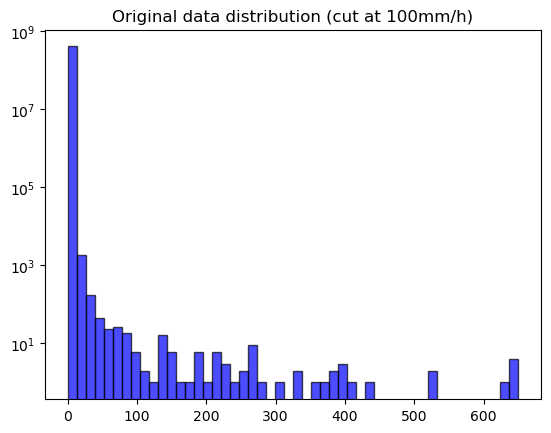

In [95]:
plt.hist(data_plotting.flatten(), bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.title('Original data distribution (cut at 100mm/h)')
plt.show()

In [96]:
# Using the db transformation of PySTEPS
 # For some reason pysteps seems to change shit in data_plotting
R = data_plotting.copy()
R_normed = transformation.dB_transform(R, threshold=0.1, zerovalue=-15.0)[0] #This returns a tuple with metatdata, where first entry is actual data
R_normed_flattened = R_normed.flatten()
print(f'Min val imn data_plotting: {np.nanmin(data_plotting)}')

Min val imn data_plotting: 0.0


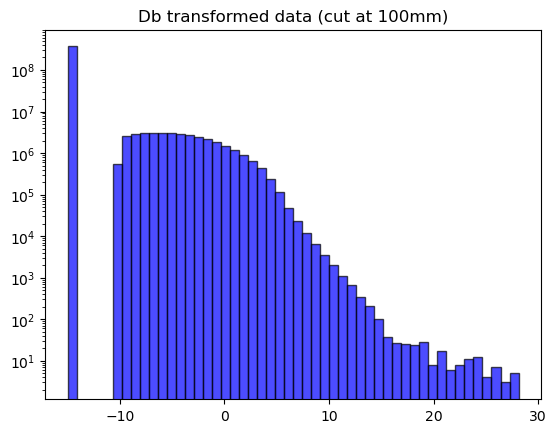

In [97]:
plt.hist(R_normed.flatten(), bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.yscale('log')
plt.title('Db transformed data (cut at 100mm)')
plt.show()

In [98]:
# Set nowcast parameters
n_ens_members = 20
n_leadtimes = 6
seed = 24
timestep = 5


In [99]:
# Estimate the motion field
V = dense_lucaskanade(R_normed[-3:, :, :])

In [100]:
# The STEPS nowcast
nowcast_method = nowcasts.get_method("steps")
R_normed_f = nowcast_method(
    R_normed[-3:, :, :],
    V,
    n_leadtimes,
    n_ens_members,
    n_cascade_levels=6,
    R_thr=-10.0,
    kmperpixel=1.0,
    timestep=timestep,  
    noise_method="nonparametric",
    vel_pert_method="bps",
    mask_method="incremental",
    seed=seed,
)

# Back-transform to rain rates
R_f = transformation.dB_transform(R_normed_f, threshold=-10.0, inverse=True)[0]

/Users/jan/miniforge3/envs/pysteps/lib/python3.10/site-packages/pysteps/decorators.py:307: FutureWarning: Argument 'R_thr' has been renamed to 'precip_thr'. This will raise a TypeError in pysteps 1.8.0.
  warnings.warn(


Computing STEPS nowcast
-----------------------

Inputs
------
input dimensions: 1200x1100
km/pixel:         1.0
time step:        5 minutes

Methods
-------
extrapolation:          semilagrangian
bandpass filter:        gaussian
decomposition:          fft
noise generator:        nonparametric
noise adjustment:       no
velocity perturbator:   bps
conditional statistics: no
precip. mask method:    incremental
probability matching:   cdf
FFT method:             numpy
domain:                 spatial

Parameters
----------
number of time steps:     6
ensemble size:            20
parallel threads:         1
number of cascade levels: 6
order of the AR(p) model: 2
velocity perturbations, parallel:      10.88,0.23,-7.68
velocity perturbations, perpendicular: 5.76,0.31,-2.72
precip. intensity threshold: -10.0
************************************************
* Correlation coefficients for cascade levels: *
************************************************
---------------------------------------

In [101]:
R_f.shape # RF: (n_ens_members,num_timesteps,m,n)

(20, 6, 1200, 1100)

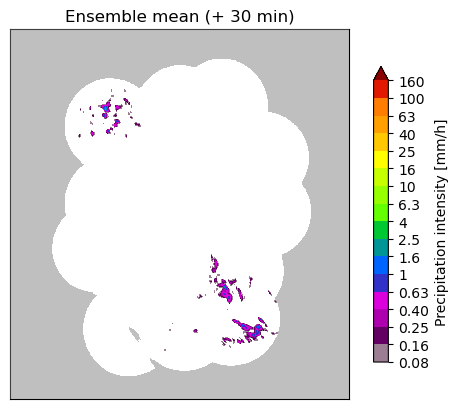

In [102]:
# Plot the ensemble mean
R_f_mean = np.mean(R_f[:, 3, :, :], axis=0)
plot_precip_field(
    R_f_mean,
    title="Ensemble mean (+ %i min)" % (n_leadtimes * timestep),
)
plt.show()

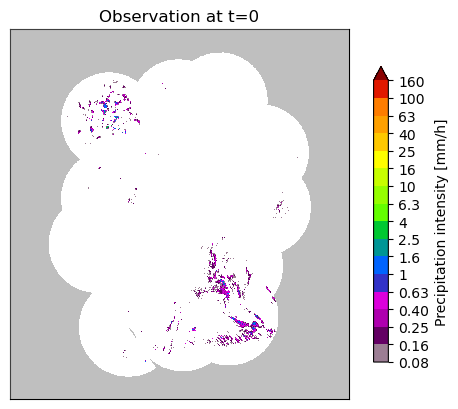

In [103]:
plot_precip_field(
    R[-1, :, :],
    title="Observation at t=0",
)
plt.show()

In [104]:
dataset['RV_recalc'].x

<xarray.DataArray 'x' (x: 1100)> Size: 9kB
array([-543.462167, -542.462167, -541.462167, ...,  553.537833,  554.537833,
        555.537833])
Coordinates:
    step     timedelta64[ns] 8B 00:00:00
  * x        (x) float64 9kB -543.5 -542.5 -541.5 -540.5 ... 553.5 554.5 555.5